## Overview
The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.

### Metrics
There are six labels, the results are evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column. So the performance metrics for the model is AUC of each label.

### Packages

In [1]:
reset -f

In [2]:
import pandas as pd
import numpy as np
import re, string
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Loading data

In [3]:
train  = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
test_y  = pd.read_csv("data/test_labels.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


#### Display the comment length

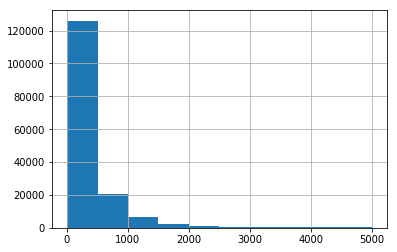

In [7]:
comment_len = train.comment_text.str.len() 
comment_len.hist()

#### Plot the labeled data frequency. there is clas imbalance.

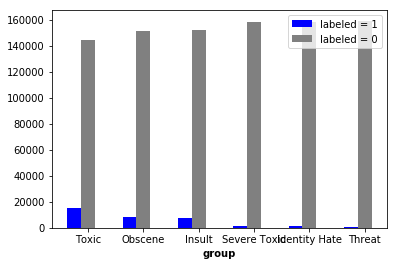

In [8]:
 barWidth = 0.25

bars1 = [sum(train['toxic']==1), sum(train['obscene']==1), sum(train['insult']==1), sum(train['severe_toxic']==1),
              sum(train['identity_hate']==1), sum(train['threat']==1)]
bars2 = [sum(train['toxic']==0), sum(train['obscene']==0), sum(train['insult']==0), sum(train['severe_toxic']==0),
              sum(train['identity_hate']==0), sum(train['threat']==0)]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='blue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='grey', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 
                                                      'Threat'])
plt.legend()
plt.show()

In [9]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

#### Words contributing the most

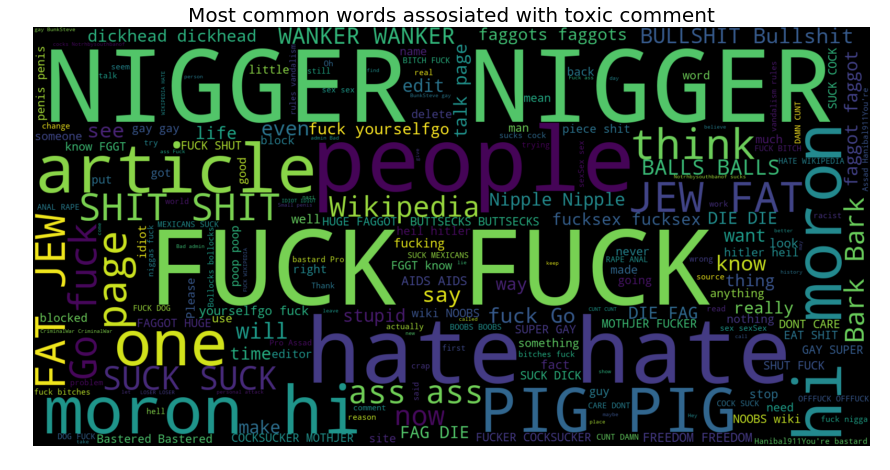

In [10]:
toxic_context = train[train.toxic == 1]   
toxic_text = toxic_context.comment_text
neg_text = pd.Series(toxic_text).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

%matplotlib inline
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words assosiated with toxic comment", size=20)
plt.show()

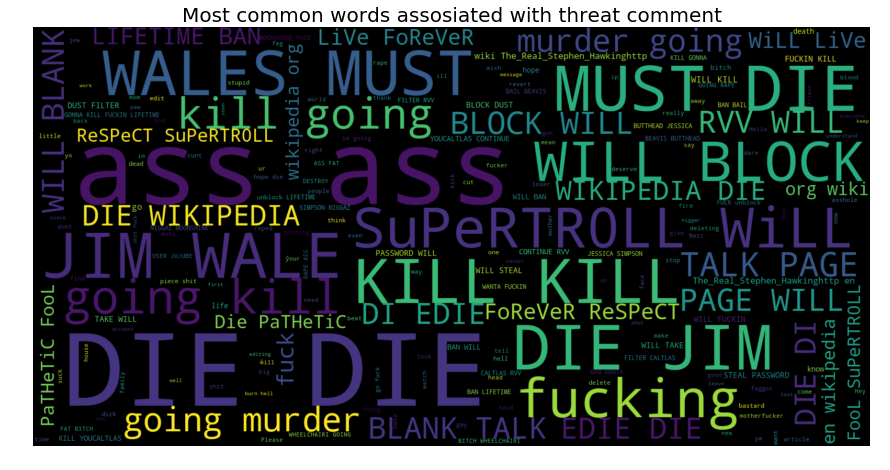

In [11]:
threat_context = train[train.threat == 1]   
threat_text = threat_context.comment_text
neg_text = pd.Series(threat_text).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

%matplotlib inline
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words assosiated with threat comment", size=20)
plt.show()

### Modeling

In [12]:
test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [13]:
def tokenize(text):
    text=text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words=nopunct.split(' ')
    lmtzr=WordNetLemmatizer()
    words=[lmtzr.lemmatize(w) for w in words]
    words=[w for w in words if len(w)>2]
    return words

In [14]:
vect1 = TfidfVectorizer(stop_words='english', ngram_range=(1,2), analyzer = 'word', min_df=10)
X_train_vec1 = vect1.fit_transform(train['comment_text'])
X_test_vec1 = vect1.transform(test['comment_text'])

In [17]:
vect2 = TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
            strip_accents='unicode', use_idf=1, min_df=10)
X_train_vec2 = vect2.fit_transform(train['comment_text'])
X_test_vec2 = vect2.transform(test['comment_text'])

In [15]:
clf1 = LogisticRegression()
clf2 = MultinomialNB()

In [16]:
def score(classifier, X_train, y_train, X_test, y_test):
    methods = []
    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
    
        auc = roc_auc_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        precision = precision_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        recall = recall_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        f1 = f1_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])

        conf_mat = confusion_matrix(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        methods.append([label,auc,precision,recall,f1,conf_mat])
        
    return methods


In [18]:
methods1=pd.DataFrame(score(clf1, X_train_vec1, train, X_test_vec1, test_y))
methods1.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf with Logistic")
methods1

********************
Tfidf with Logistic


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.816785,0.671287,0.667980,0.669630,"[[55896, 1992], [2022, 4068]]"
1,severe_toxic,0.685920,0.341584,0.376022,0.357977,"[[63345, 266], [229, 138]]"
2,obscene,0.800361,0.751827,0.613113,0.675422,"[[59540, 747], [1428, 2263]]"
3,threat,0.570761,0.416667,0.142180,0.212014,"[[63725, 42], [181, 30]]"
4,insult,0.755725,0.683112,0.525241,0.593863,"[[59716, 835], [1627, 1800]]"
5,identity_hate,0.631264,0.661972,0.264045,0.377510,"[[63170, 96], [524, 188]]"


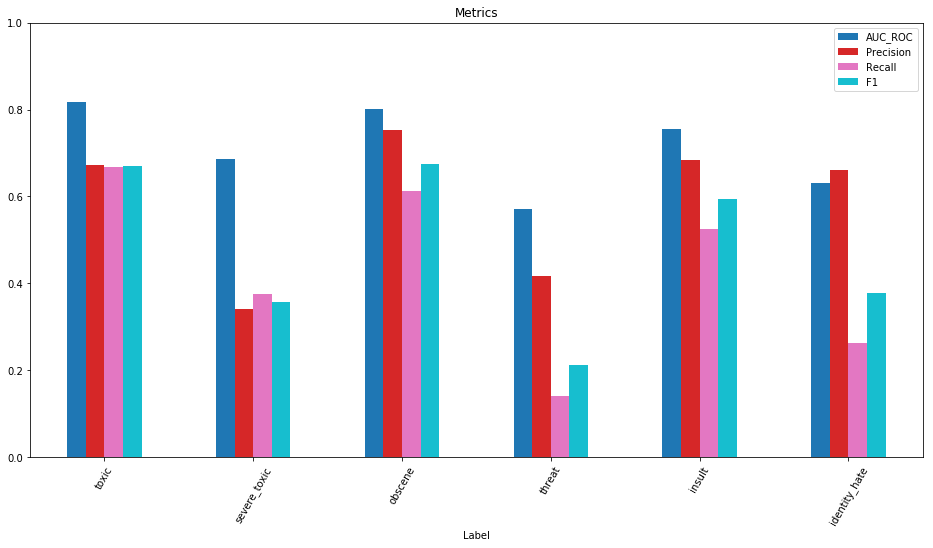

In [19]:
methods1.set_index(["Label"],inplace=True)
%matplotlib inline
methods1.plot(figsize=(16, 8),kind='bar',title='Metrics', rot=60, ylim=(0.0,1),
             colormap='tab10')

In [20]:
methods2=pd.DataFrame(score(clf1, X_train_vec2, train, X_test_vec2, test_y))
methods2.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf + lamme with Logistic")
methods2

********************
Tfidf + lamme with Logistic


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.831175,0.653511,0.701478,0.676645,"[[55623, 2265], [1818, 4272]]"
1,severe_toxic,0.655206,0.380795,0.313351,0.343797,"[[63424, 187], [252, 115]]"
2,obscene,0.800209,0.751245,0.612842,0.675022,"[[59538, 749], [1429, 2262]]"
3,threat,0.596858,0.518987,0.194313,0.282759,"[[63729, 38], [170, 41]]"
4,insult,0.756923,0.722892,0.525241,0.608416,"[[59861, 690], [1627, 1800]]"
5,identity_hate,0.622253,0.683594,0.245787,0.361570,"[[63185, 81], [537, 175]]"


In [21]:
methods3=pd.DataFrame(score(clf2, X_train_vec1, train, X_test_vec1, test_y))
methods3.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf with Multinomial")
methods3

********************
Tfidf with Multinomial


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.541358,0.976789,0.082923,0.152868,"[[57876, 12], [5585, 505]]"
1,severe_toxic,0.500000,0.000000,0.000000,0.000000,"[[63611, 0], [367, 0]]"
2,obscene,0.524350,0.978261,0.048767,0.092903,"[[60283, 4], [3511, 180]]"
3,threat,0.500000,0.000000,0.000000,0.000000,"[[63767, 0], [211, 0]]"
4,insult,0.504806,0.970588,0.009629,0.019070,"[[60550, 1], [3394, 33]]"
5,identity_hate,0.500000,0.000000,0.000000,0.000000,"[[63266, 0], [712, 0]]"


In [22]:
methods4=pd.DataFrame(score(clf2, X_train_vec2, train, X_test_vec2, test_y))
methods4.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf + lemme with Multinomial")
methods4

********************
Tfidf + lemme with Multinomial


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.610774,0.858662,0.225452,0.357134,"[[57662, 226], [4717, 1373]]"
1,severe_toxic,0.499961,0.000000,0.000000,0.000000,"[[63606, 5], [367, 0]]"
2,obscene,0.568260,0.883478,0.137632,0.238162,"[[60220, 67], [3183, 508]]"
3,threat,0.500000,0.000000,0.000000,0.000000,"[[63767, 0], [211, 0]]"
4,insult,0.527446,0.789256,0.055734,0.104116,"[[60500, 51], [3236, 191]]"
5,identity_hate,0.499984,0.000000,0.000000,0.000000,"[[63264, 2], [712, 0]]"


In [23]:
clf3 = svm.LinearSVC(class_weight = {1:20})

In [24]:
methods5=pd.DataFrame(score(clf3, X_train_vec1, train, X_test_vec1, test_y))
methods5.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf with LinearSVC")
methods5

********************
Tfidf with LinearSVC


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.891356,0.520616,0.866667,0.650481,"[[53028, 4860], [812, 5278]]"
1,severe_toxic,0.779876,0.252415,0.569482,0.349791,"[[62992, 619], [158, 209]]"
2,obscene,0.878978,0.571874,0.794365,0.665003,"[[58092, 2195], [759, 2932]]"
3,threat,0.731036,0.392000,0.464455,0.425163,"[[63615, 152], [113, 98]]"
4,insult,0.851531,0.536994,0.739130,0.622053,"[[58367, 2184], [894, 2533]]"
5,identity_hate,0.772065,0.551481,0.549157,0.550317,"[[62948, 318], [321, 391]]"


In [25]:
methods6=pd.DataFrame(score(clf3, X_train_vec2, train, X_test_vec2, test_y))
methods6.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf + lemme with LinearSVC")
methods6

********************
Tfidf + lemme with LinearSVC


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.877162,0.437912,0.872085,0.583050,"[[51071, 6817], [779, 5311]]"
1,severe_toxic,0.832440,0.194099,0.681199,0.302115,"[[62573, 1038], [117, 250]]"
2,obscene,0.875403,0.506531,0.798429,0.619834,"[[57416, 2871], [744, 2947]]"
3,threat,0.759001,0.341615,0.521327,0.412758,"[[63555, 212], [101, 110]]"
4,insult,0.842233,0.433510,0.739130,0.546494,"[[57241, 3310], [894, 2533]]"
5,identity_hate,0.779352,0.387560,0.568820,0.461013,"[[62626, 640], [307, 405]]"


### Model comparison

In [26]:
def drawConfusionMatrix(cm):

    ax = plt.axes()
    sns.heatmap(cm,
           annot=True,
           annot_kws={"size": 16},
           fmt='d',
           cmap="YlGnBu",
           linewidths=2, 
           linecolor='yellow',
           xticklabels=("Non-toxic","Toxic"),
           yticklabels=("Non-toxic","Toxic"))

    plt.ylabel('True',fontsize=18)
    plt.xlabel('Predicted',fontsize=18)
    plt.show()

***************Toxic labelling***************
*********************************************


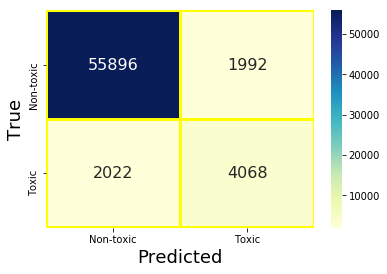

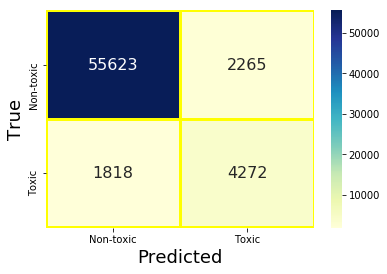

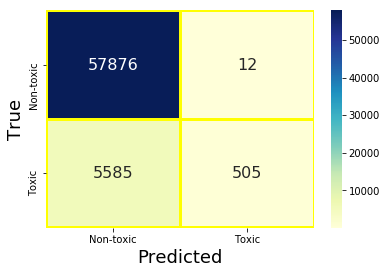

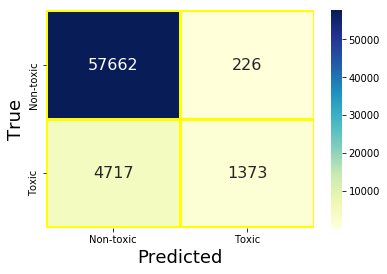

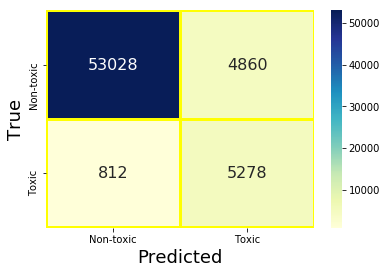

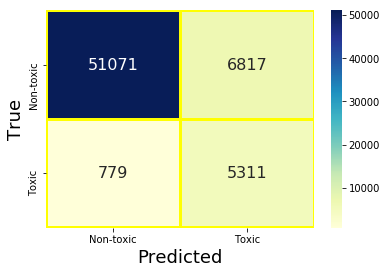

In [27]:
methods = [ methods1, methods2, methods3, methods4, methods5, methods6]
print("***************Toxic labelling***************")
print("*********************************************")
for i in range(0,6):
    cm = methods[i]["Confussion_Matrix"][0]
    drawConfusionMatrix(cm)

In [28]:
# pipe_lr_tf = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), analyzer = 'word')),
#     ('lr', LogisticRegression())
# ])

# pipe_lr_tf2 = Pipeline([
#     ('tfidf', TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
#             strip_accents='unicode', use_idf=1)),
#     ('lr', LogisticRegression())
# ])
    
# pipe_mnb_tf = Pipeline([
#     ('tfidf', TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
#             strip_accents='unicode', use_idf=1)),
#     ('nb', MultinomialNB())
# ])
# pipelines = [pipe_lr_tf, pipe_lr_tf2, pipe_mnb_tf]

In [29]:
# for pipe in pipelines:
#         for label in test_labels:
#             pipe.fit(train['comment_text'], train[label])
    